In [7]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from matplotlib import pyplot as plt
import numpy as np

# Preprocessing Notebook

### Dataset loading

In [8]:
# Load data

y_data = {}
y_test_data = pd.read_csv(f"../data/test.csv")
X_test_estimated_data = {}
X_train_estimated_data = {}
X_train_observed_data = {}
locations = ["A", "B", "C"]

for location in locations:
    y_data[location] = pd.read_parquet(f"../data/{location}/train_targets.parquet")

    X_test_estimated_data[location] = pd.read_parquet(
        f"../data/{location}/X_test_estimated.parquet"
    )
    X_train_estimated_data[location] = pd.read_parquet(
        f"../data/{location}/X_train_estimated.parquet"
    )
    X_train_observed_data[location] = pd.read_parquet(
        f"../data/{location}/X_train_observed.parquet"
    )

In [9]:
# Combine data

combine_data = (
    lambda data: pd.concat(data.values(), keys=data.keys())
    .reset_index()
    .drop(columns="level_1")
    .rename(columns={"level_0": "location"})
)

y = combine_data(y_data).sort_values(by=["time", "location"])

y_test_data = y_test_data.rename(columns={"prediction": "pv_measurement"})
y_test_data = y_test_data[["time", "location", "pv_measurement"]]

# Add Kaggle test data to y
y = pd.concat([y, y_test_data]).sort_values(by=["time", "location"])
y["time"] = pd.to_datetime(y["time"])

X_train_observed = combine_data(X_train_observed_data).assign(data_type="observed")
X_train_estimated = combine_data(X_train_estimated_data).assign(data_type="estimated")
X_test_estimated = combine_data(X_test_estimated_data).assign(data_type="test")

X = pd.concat([X_train_observed, X_train_estimated, X_test_estimated]).sort_values(
    by=["date_forecast", "location"]
)

print("X shape:", X.shape)
print("y shape:", y.shape)

C:\Users\krist\AppData\Local\Temp\ipykernel_20432\3349527316.py:16: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  y = pd.concat([y, y_test_data]).sort_values(by=["time", "location"])


X shape: (413791, 49)
y shape: (101248, 3)


### Data cleaning

#### Resample data to hourly granularity

In [10]:
# Custom aggregation function
def custom_resample(aggregation_dict): 
    result = {}
    for column in X.columns:
        if column in ["date_forecast"]:
            continue

        aggregation = aggregation_dict.get(column, 'mean')  # Use 'mean' by default

        result[column] = aggregation
    return result

# Specify the aggregation method for specific columns
aggregation_dict = {
    "location": "first",
    "data_type": "first",

    # Categorical weather features
    "is_day:idx": "first",
    "is_in_shadow:idx": "first",
    "precip_type_5min:idx": "first",
    "dew_or_rime:idx": "first",
    "snow_drift:idx": "first",
}

X = (
    X.set_index("date_forecast")
    .groupby("location")
    .resample("H")
    .apply(custom_resample(aggregation_dict))
    .drop(columns=["location"])
    .reset_index()
    .sort_values(by=["date_forecast", "location"])
    .reset_index(drop=True)
)

#### Remove NaN rows

In [11]:
# Find all rows that only contain NaN in X

nan_rows = X[X.drop(columns=["date_forecast", "location"]).isna().all(axis=1)].index

X = X.drop(nan_rows).reset_index(drop=True)
display(X.describe())

# Find all rows that only contain NaN in y

nan_rows = y[y.drop(columns=["time", "location"]).isna().all(axis=1)].index

y = y.drop(nan_rows).reset_index(drop=True)
display(y.describe())

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,103450.000000,103450.000000,85710.000000,1.034500e+05,103450.000000,95988.000000,103450.000000,103450.000000,103450.000000,1.034500e+05,...,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000
mean,6.022451,1.255468,2818.218750,5.340856e+05,148.357071,1728.615723,0.002707,275.193604,40.692169,1.464918e+05,...,179.593079,-0.686007,0.056825,279.437866,73.615753,33047.601562,3.017211,0.677701,0.670877,0.000048
std,2.766890,0.037343,2490.028320,8.361419e+05,232.916977,1777.659424,0.254843,7.007302,61.684486,2.194368e+05,...,97.451599,24.151138,0.105932,6.689621,34.070358,17768.091797,1.743118,2.773536,1.871685,0.006387
min,0.500000,1.139250,27.600000,0.000000e+00,0.000000,27.299997,-1.000000,247.425003,0.000000,0.000000e+00,...,6.983000,-49.931999,0.000000,258.024994,0.000000,132.375000,0.025000,-7.225000,-8.400000,-0.100000
25%,4.000000,1.230000,1063.206177,0.000000e+00,0.000000,602.687500,0.000000,270.600006,0.000000,0.000000e+00,...,94.335381,-17.985250,0.000000,274.799988,52.900002,17214.430664,1.675000,-1.325000,-0.600000,0.000000
50%,5.450000,1.255000,1847.675049,1.444562e+04,2.350000,1170.074951,0.000000,275.000000,1.400000,1.314446e+04,...,180.008751,-0.422625,0.000000,278.700012,93.025002,36858.449219,2.675000,0.325000,0.700000,0.000000
75%,7.900000,1.279000,3831.431152,8.463045e+05,233.250000,2085.399902,0.000000,280.649994,68.193748,2.444780e+05,...,264.694176,16.086188,0.100000,284.093758,99.925003,48121.931641,4.025000,2.500000,1.850000,0.000000
max,18.700001,1.441000,12294.901367,2.990596e+06,835.650024,11673.724609,1.000000,294.924988,334.750000,1.198315e+06,...,348.487518,49.943748,1.375000,303.250000,100.000000,75489.328125,13.275000,11.200000,8.825000,0.100000


,pv_measurement
count,95184.000000
mean,280.506347
std,758.866540
min,0.000000
25%,0.000000
50%,0.000000
75%,161.287500
max,5733.420000


#### Remove outliers

In [12]:
# Remove outliers

detection_data = X.drop(
    columns=["date_forecast", "location", "date_calc", "data_type"]
).fillna(0)

outlier_detector = IsolationForest(
    n_estimators=100, contamination=0.01, random_state=42
).fit(detection_data)

outlier_mask = outlier_detector.predict(detection_data) == 1

C:\Users\krist\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [13]:
# Remove repeated values


def find_repeated_indexes(df, column_name, repeat_count=12, ignore_zeros=True) -> list:
    """
    Find and return the indexes of rows with a specified number of repeated values in a given column.

    Parameters:
    - df: DataFrame to search for repeated rows.
    - column_name: Name of the column to check for repeated values.
    - repeat_count: Number of repeated values required to consider a row as a match.

    Returns:
    - List of indexes for rows with the specified number of repeated values in the given column.
    """
    repeated_indexes = []
    temp_repeated_indexes = []
    current_value = None

    for index, row in df.iterrows():
        value = row[column_name]

        if value == 0 and ignore_zeros:
            continue

        if value == current_value:
            temp_repeated_indexes.append(index)
        else:
            current_value = value
            if len(temp_repeated_indexes) <= repeat_count:
                temp_repeated_indexes.clear()
            else:
                repeated_indexes.extend(
                    set(temp_repeated_indexes) - set(repeated_indexes)
                )
                temp_repeated_indexes.clear()

    return repeated_indexes


for location in locations:
    # Drop rows with repeated values over 24 hours
    repeated_indexes = find_repeated_indexes(
        y[y.location == location].sort_values(by=["location", "time"]),
        "pv_measurement",
        repeat_count=24,
        ignore_zeros=True,
    )

    y = y.drop(repeated_indexes).reset_index(drop=True)

    # Drop rows with repeated zeros over 4 days,
    # ignore dates after '2023-05-01 00:00:00' as they are test data

    repeated_indexes = find_repeated_indexes(
        y[(y.location == location) & (y.time <= "2023-05-01 00:00:00")].sort_values(
            by=["location", "time"]
        ),
        "pv_measurement",
        repeat_count=72,
        ignore_zeros=False,
    )

    y = y.drop(repeated_indexes).reset_index(drop=True)

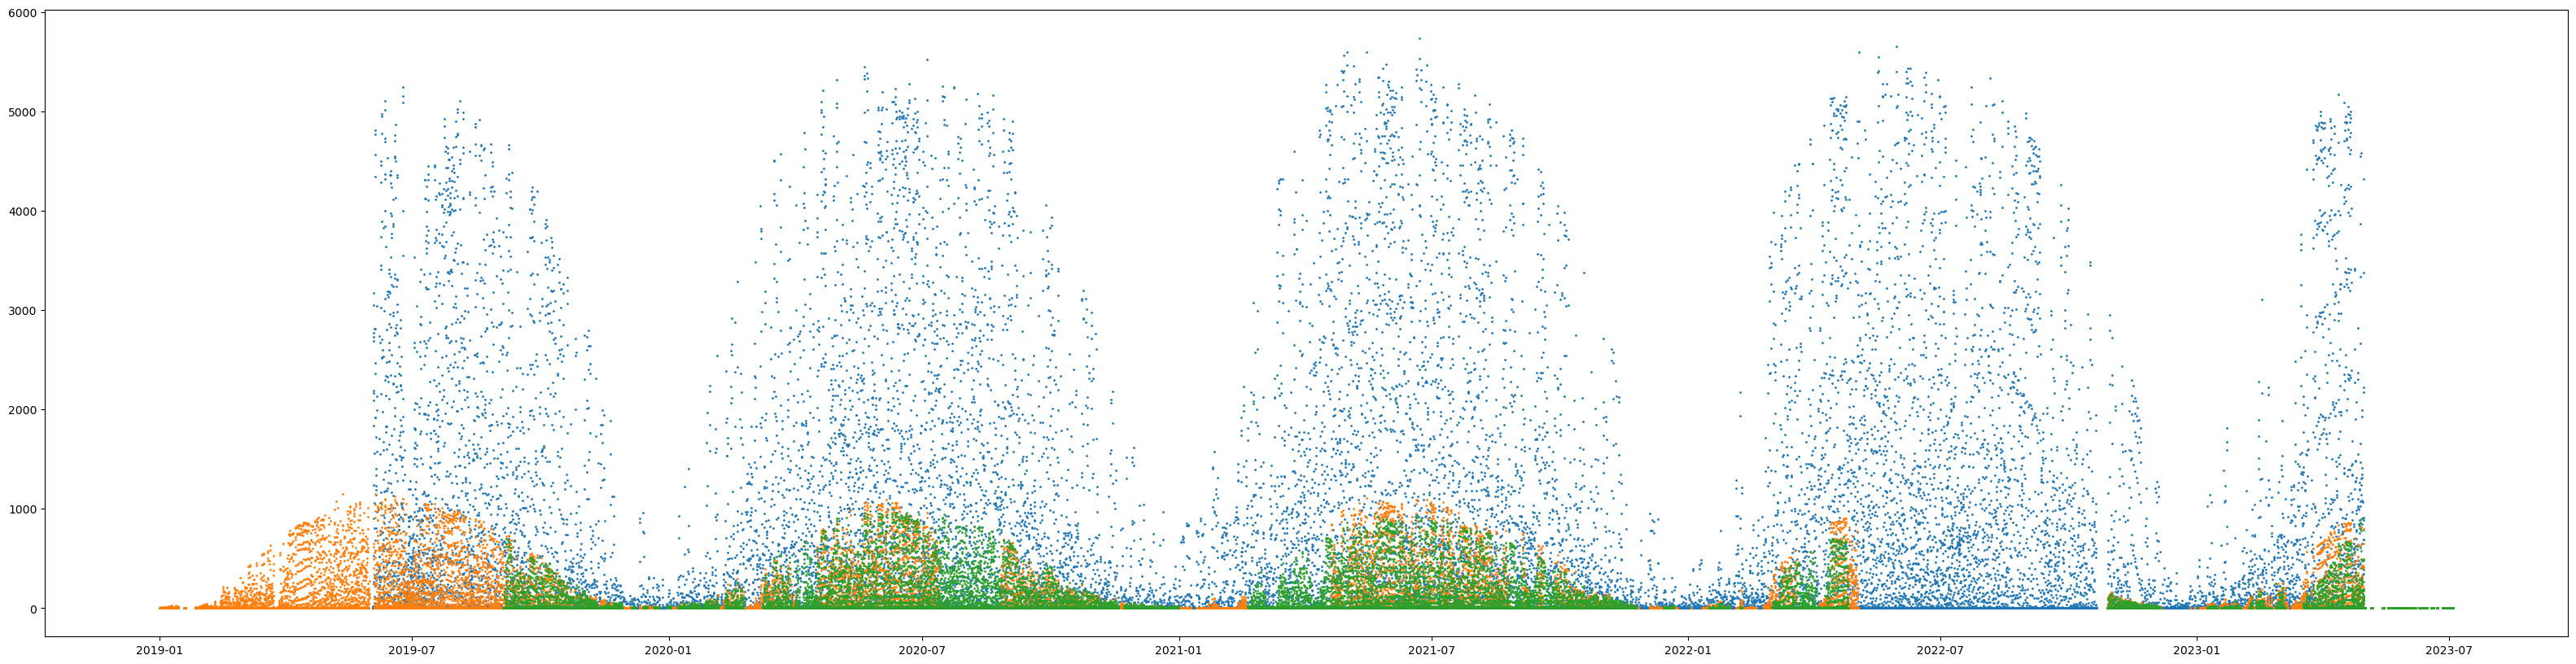

In [14]:
plt.figure(figsize=(40, 10))

for location in locations:
    plt.scatter(y[y.location == location].time, y[y.location == location]["pv_measurement"], s=1)


### Combine X and y

In [15]:
# Combine X and y on date_forecast and location. Drop rows where a row does not exist in both X and y.

data = pd.merge(
    X, y, left_on=["date_forecast", "location"], right_on=["time", "location"]
).drop(columns=["time"])

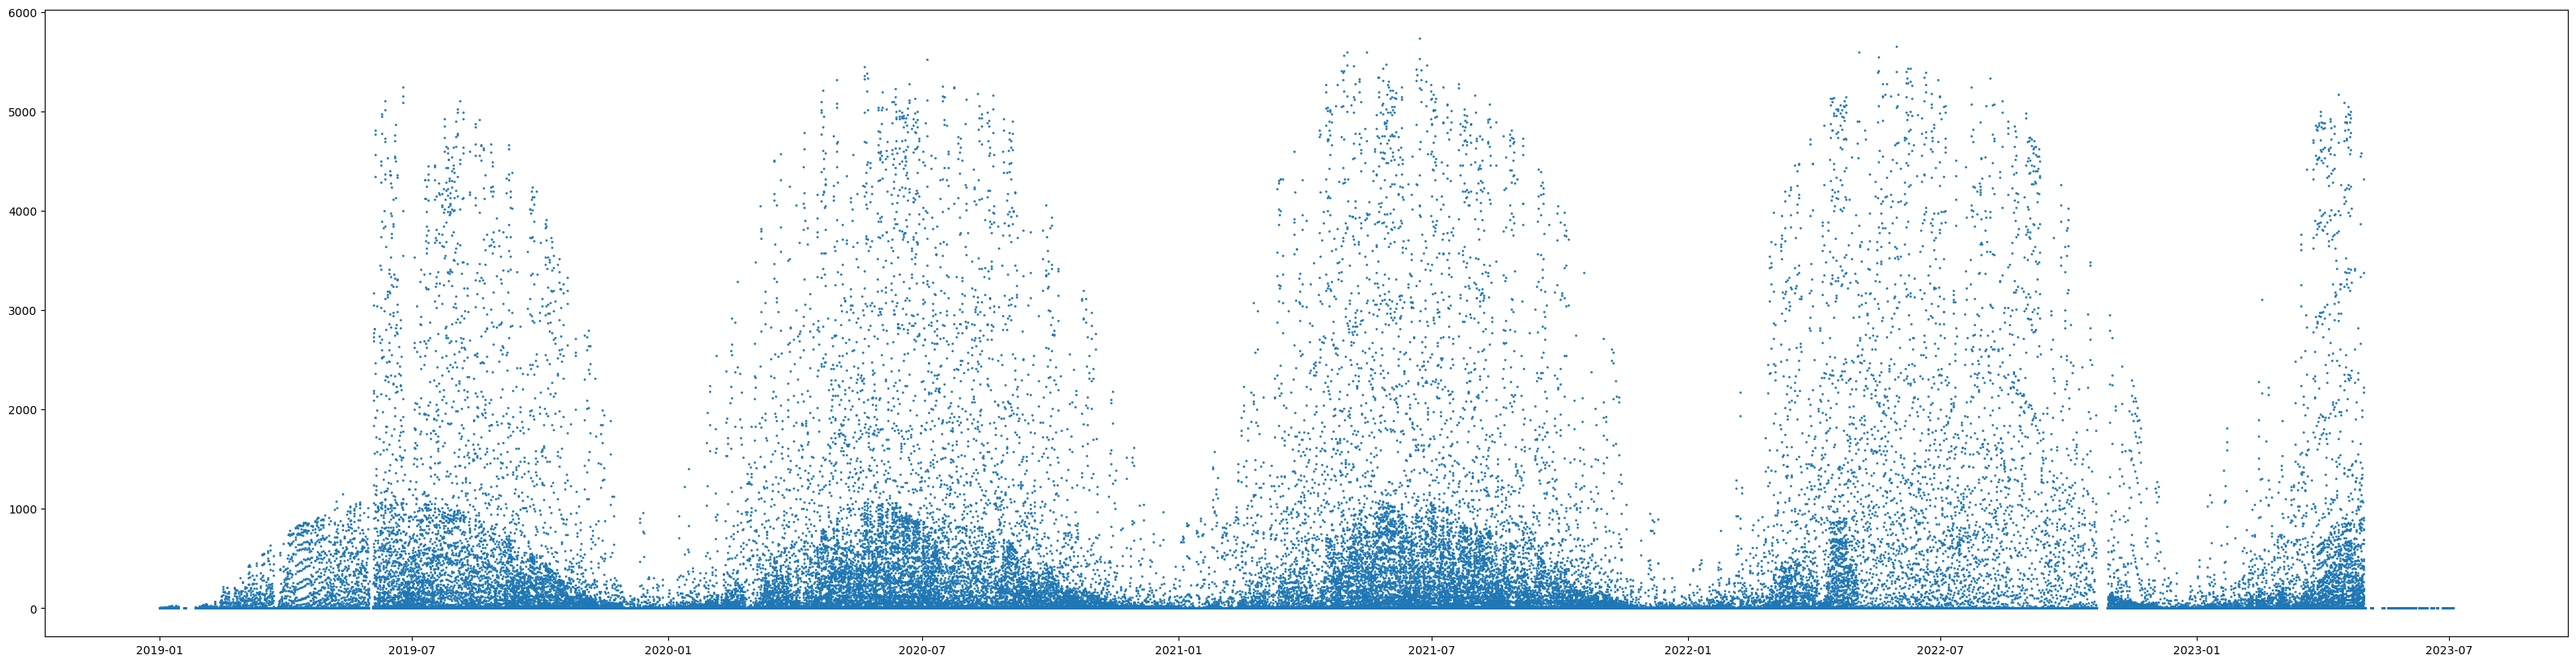

In [16]:
plt.figure(figsize=(40, 10))
plt.scatter(data.date_forecast, data["pv_measurement"], s=1)

### Feature Engineering

#### Add sinus and cosinus features

In [17]:
# Function that sinus and cosinus transform a column

def add_sin_cos(df, column_name, period):
    """
    Add sinus and cosinus transformed columns for the given column.

    Parameters:
    - df: DataFrame to add the transformed columns to.
    - column_name: Name of the column to transform.
    - period: Period of the sinus and cosinus functions.
    """
    df[f"{column_name}_sin"] = np.sin(2 * np.pi * df[column_name] / period)
    df[f"{column_name}_cos"] = np.cos(2 * np.pi * df[column_name] / period)

# Add sinus and cosinus transformed columns for time

data["hour"] = data["date_forecast"].dt.hour
data["month"] = data["date_forecast"].dt.month

add_sin_cos(data, "hour", 24)
add_sin_cos(data, "month", 12)

### Result

In [18]:
data.describe().T.drop(columns=["std", "25%", "50%", "75%"])

,count,mean,min,max
absolute_humidity_2m:gm3,85205.0,6.214849,0.700000,1.735000e+01
air_density_2m:kgm3,85205.0,1.252912,1.139250,1.426250e+00
ceiling_height_agl:m,69963.0,2903.989258,27.849998,1.229490e+04
clear_sky_energy_1h:J,85205.0,553656.875000,0.000000,2.990596e+06
clear_sky_rad:W,85205.0,153.780457,0.000000,8.356500e+02
cloud_base_agl:m,78892.0,1748.616577,27.500000,1.167362e+04
dew_or_rime:idx,85205.0,0.015879,-1.000000,1.000000e+00
dew_point_2m:K,85205.0,275.824036,251.050003,2.936250e+02
diffuse_rad:W,85205.0,41.908321,0.000000,3.347500e+02
diffuse_rad_1h:J,85205.0,150879.968750,0.000000,1.198315e+06


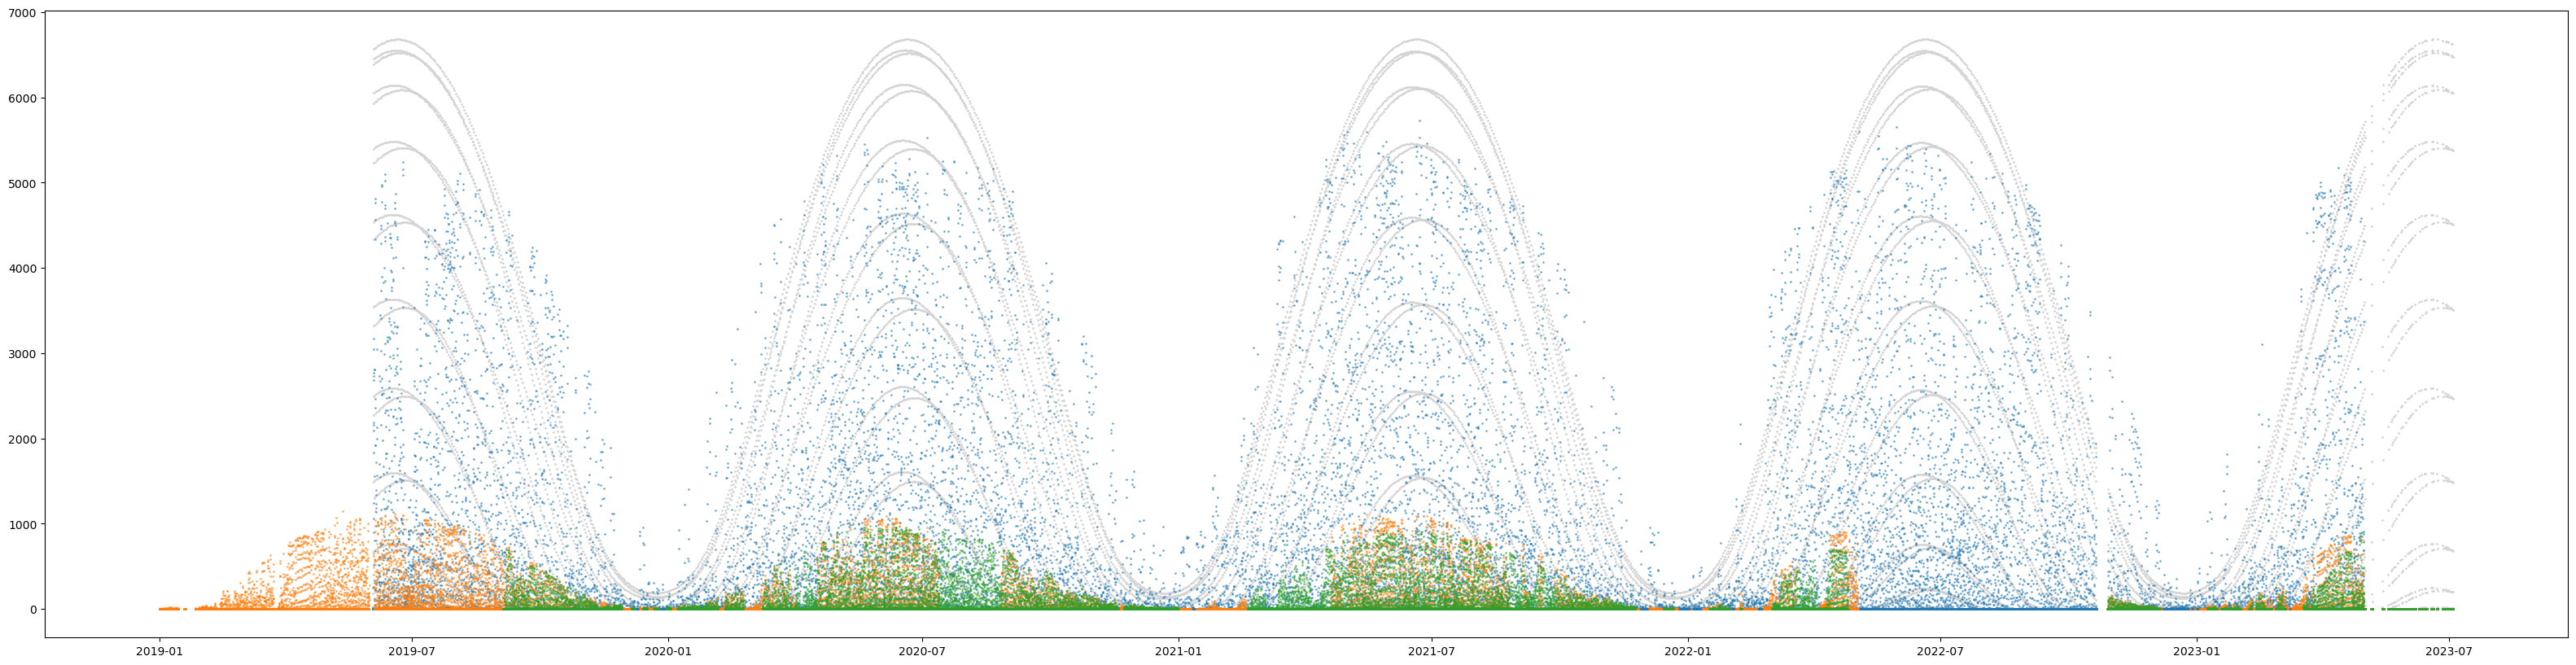

In [19]:
# Plot alignment and values
plt.figure(figsize=(40, 10))

plt.scatter(
    data[data.location == "A"].date_forecast,
    data[data.location == "A"]["clear_sky_rad:W"] * 8,
    s=1,
    color="lightgrey",
)

for loc in locations:
    plt.scatter(
        data[data.location == loc].date_forecast,
        data[data.location == loc]["pv_measurement"],
        s=1,
        alpha=0.5,
    )


In [21]:
# Export to CSV

data.to_csv("../data/processed/data.csv", index=False)